Play the communication game from visual input

### Train

In [1]:
import argparse
import os
import sys
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms

import egg.core as core
from input_image.features import ImageNetFeat, ImagenetLoader
from input_image.train import parse_arguments, loss, loss_nll, get_game

In [2]:
seed = 1110

sys.argv = f'--root=./data/formatted/image --n_epochs=50 --batch_size=16 \
--lr=0.005 --random_seed={seed} --checkpoint_dir=./save/input_image/seed_{seed}'.split(' ')

In [3]:
opts = parse_arguments()

dataset_train = ImageNetFeat(root=os.path.join(opts.root, "./data/formatted/image/train"))
dataset_test = ImageNetFeat(root=os.path.join(opts.root, "./data/formatted/image/test/"))

train_loader = ImagenetLoader(dataset_train, batch_size=opts.batch_size, shuffle=False, opt=opts,
                              batches_per_epoch=opts.batches_per_epoch, seed=None)
validation_loader = ImagenetLoader(dataset_test, opt=opts, batch_size=opts.batch_size, shuffle=False,
                                   batches_per_epoch=opts.batches_per_epoch,
                                   seed=None)

In [4]:
game = get_game(opts)
optimizer = core.build_optimizer(game.parameters())
callback = None
if opts.mode == 'gs':
    callbacks = [core.TemperatureUpdater(
        agent=game.sender, decay=0.9, minimum=0.1)]
else:
    callbacks = []

callbacks.append(core.ConsoleLogger(as_json=True, print_train_loss=True))
trainer = core.Trainer(game=game, optimizer=optimizer, train_data=train_loader,
                       validation_data=validation_loader, callbacks=callbacks)

Take a few minutes

In [5]:
%%capture cap --no-stderr
trainer.train(n_epochs=opts.n_epochs)

In [6]:
with open(f'./save/input_image/seed_{seed}/seed_{seed}', 'w') as f:
    f.writelines(cap.stdout)

### Plot results

In [1]:
import os
import json
import seaborn as sns
import pandas as pd

In [2]:
def read_log(log_folder):
    paths = []
    for parent, _, filenames in os.walk(log_folder):
        for f in filenames:
            if 'seed' in f:
                paths.append(os.path.join(parent, f))

    line_list = []
    for i in range(len(paths)):
        with open(paths[i]) as f:
            for line in f:
                item = json.loads(line)
                item['seed'] = paths[i].split('/')[-1].split('_')[1]
                line_list.append(item)

    df = pd.DataFrame(line_list)
    return df

In [3]:
df_image = read_log('./save/input_image/')

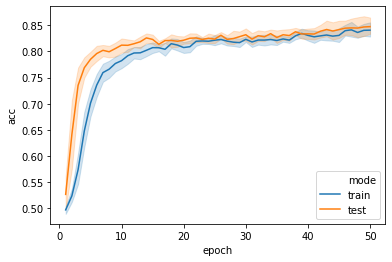

In [4]:
sns.lineplot(data=df_image, x='epoch', y='acc', hue='mode')

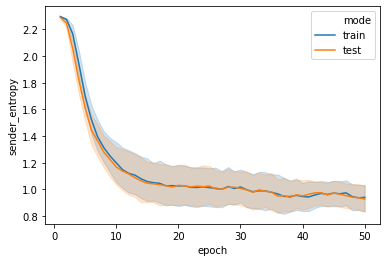

In [5]:
sns.lineplot(data=df_image, x='epoch', y='sender_entropy', hue='mode')

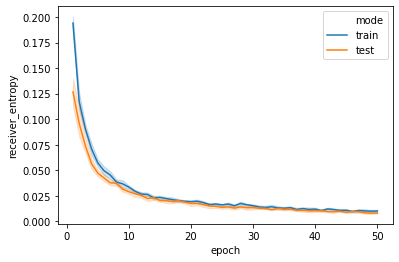

In [6]:
sns.lineplot(data=df_image, x='epoch', y='receiver_entropy', hue='mode')

### Extract binary vectors

In [5]:
trainer.load_from_checkpoint('./save/model/final.tar')

# loading trainer state from ./save/model/final.tar


In [7]:
net = trainer.game.sender.agent
# net = net.eval()
net

InformedSender(
  (lin1): Linear(in_features=64, out_features=50, bias=True)
  (conv2): Conv2d(1, 20, kernel_size=(2, 1), stride=(2, 1))
  (conv3): Conv2d(1, 1, kernel_size=(20, 1), stride=(20, 1))
  (lin4): Linear(in_features=50, out_features=10, bias=True)
  (conv_block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(16, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxP

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data/original/image', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=False, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data/original/image', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.fc_block.register_forward_hook(get_activation('fc_block'))



In [11]:
# features = torch.sign(torch.from_numpy(features)).numpy()

In [12]:
features, labels = [], []
for data in trainloader:
    images, label = data
    images = images.to(device)
    net(images)
    features.append(activation['fc_block'].cpu().detach().numpy())
    labels.append(label.numpy())
features = np.concatenate(features)
labels = np.concatenate(labels)

np.save(f'./save/feature/seed_{seed}/train_feature.npy', features)
np.save(f'./save/feature/seed_{seed}/train_labels.npy', labels)

In [13]:
features, labels = [], []
for data in testloader:
    images, label = data
    images = images.to(device)
    net(images)
    features.append(activation['fc_block'].cpu().detach().numpy())
    labels.append(label.numpy())
features = np.concatenate(features)
labels = np.concatenate(labels)

np.save(f'./save/feature/seed_{seed}/test_feature.npy', features)
np.save(f'./save/feature/seed_{seed}/test_labels.npy', labels)

In [13]:
features[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.], dtype=float32)